In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
import math

In [5]:
from sklearn import tree, metrics, svm

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.preprocessing import LabelBinarizer, Imputer

In [8]:
import graphviz

In [9]:
input_file="data.csv"

In [102]:
df = pd.read_csv(input_file, header = 0, sep=',', thousands=',')

In [11]:
ages = df[['iid','age']].groupby(['iid']).mean()

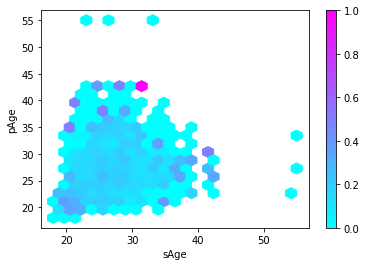

In [12]:
matches = df[['age', 'pid', 'match']].rename({'age': 'sAge'}, axis='columns')
matches['pAge'] = matches.pid.apply(lambda x: math.nan if math.isnan(x) else ages.age[x])
matches = matches.drop(['pid'], axis=1).dropna()
matches.plot.hexbin(x='sAge', y='pAge', C='match', cmap=plt.cm.cool, reduce_C_function=np.mean, gridsize=22, sharex=False, sharey=False)
plt.savefig('plot.pdf', format='pdf')
plt.savefig('plot.png', dpi=400)
plt.show()

In [182]:
# Preprocess data
X = df.copy()
X[['wave', 'attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1',
  'attr2_1','sinc2_1','intel2_1','fun2_1','amb2_1','shar2_1',
  'attr3_1','sinc3_1','intel3_1','fun3_1','amb3_1',
  'attr4_1','sinc4_1','intel4_1','fun4_1','amb4_1','shar4_1',
  'attr5_1','sinc5_1','intel5_1','fun5_1','amb5_1']].query(
    'wave >= 6 or wave <= 9').drop('wave', axis=1).apply(lambda x: x*10)

X.drop(['iid', 'id', 'idg', 'condtn', 'wave', 'round', 'position',
             'positin1', 'order', 'partner', 'pid', 'match',
             'zipcode', # zipcode -> income
             # those are classified and already removed:
             #'undergra', -> {mn_sat, tuition}
             #'from',
             #'career',
             'like', #TODO: drop it or no???
             'dec',
             'match',
             'you_call', 'them_cal', 'date_3', 'numdat_3', 'num_in_3',
            ], axis=1, inplace=True)

Y = df['dec']

# Copy to avoid looping over the array we're modifying
cols = X.columns.values
for col in cols:
    if X[col].dtypes=='object':
        print('Classifying {0}'.format(col))
        X = X.drop(col, axis=1)
        # This is really heavy
        #classes = X[col].str.get_dummies().rename(columns=lambda x: 'field-{0}'.format(x).replace(' ',''))
        #X = pd.concat([X,classes])
    elif X[col].dtypes=='float64' and X[col].isnull().values.any():
        print('Imputing {0}'.format(col))
        # fill in missing values
        if col == 'field_cd' or \
            col == 'gender' or \
            col == 'CHANGE ME': # TODO: add more classifiable fields
            X[[col]]=Imputer(missing_values='NaN', strategy='most_frequent', axis=0).fit_transform(X[[col]])
        else:
            X[[col]]=Imputer(missing_values='NaN', strategy='mean', axis=0).fit_transform(X[[col]])
        

Imputing age
Classifying field
Imputing field_cd
Classifying undergra
Imputing mn_sat
Imputing tuition
Imputing race
Imputing imprace
Imputing imprelig
Classifying from
Imputing income
Imputing goal
Imputing date
Imputing go_out
Classifying career
Imputing career_c
Imputing sports
Imputing tvsports
Imputing exercise
Imputing dining
Imputing museums
Imputing art
Imputing hiking
Imputing gaming
Imputing clubbing
Imputing reading
Imputing tv
Imputing theater
Imputing movies
Imputing concerts
Imputing music
Imputing shopping
Imputing yoga
Imputing exphappy
Imputing expnum
Imputing attr1_1
Imputing sinc1_1
Imputing intel1_1
Imputing fun1_1
Imputing amb1_1
Imputing shar1_1
Imputing attr4_1
Imputing sinc4_1
Imputing intel4_1
Imputing fun4_1
Imputing amb4_1
Imputing shar4_1
Imputing attr2_1
Imputing sinc2_1
Imputing intel2_1
Imputing fun2_1
Imputing amb2_1
Imputing shar2_1
Imputing attr3_1
Imputing sinc3_1
Imputing fun3_1
Imputing intel3_1
Imputing amb3_1
Imputing attr5_1
Imputing sinc5_1
Impu

In [183]:
def model(X,y,test_size=0.2,random_state=0):
    # Train using 80% of data
    X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=20)

    clf = tree.DecisionTreeClassifier(min_samples_split=1000)
    clf = clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_predict)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict).ravel()/len(y_test)
    print("""
    Accuracy: {0:.2f}%
    True negatives: {1:.2f}%\tFalse negatives: {2:.2f}%
    False positives: {3:.2f}%\tTrue positives: {4:.2f}%
    """.format(accuracy, tn, fp, fn, tp))

    return clf

In [184]:
def vizualize(model, out_file=None):
    return graphviz.Source(
        tree.export_graphviz(model, out_file,
                                feature_names=X.columns,
                                filled=True, rounded=True,
                                special_characters=True))


    Accuracy: 0.73%
    True negatives: 0.41%	False negatives: 0.12%
    False positives: 0.15%	True positives: 0.32%
    


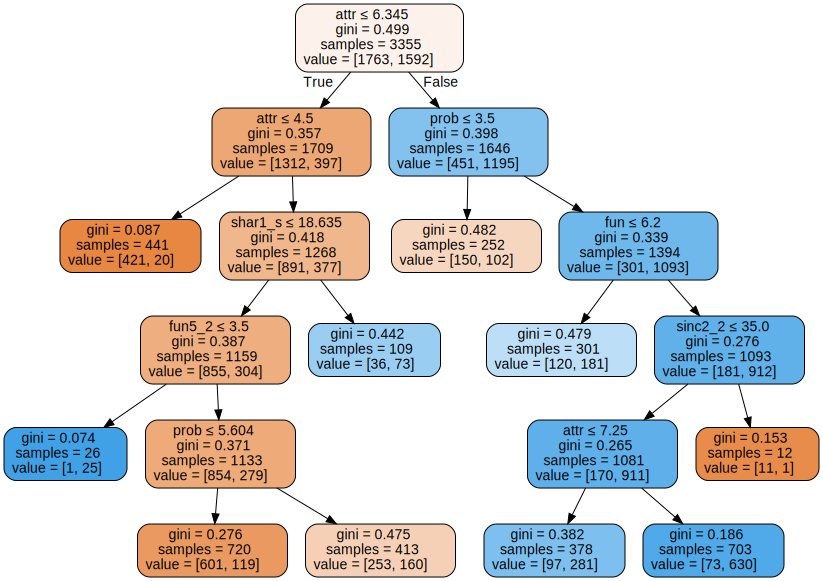

In [185]:
fem_model_80 = model(X[X.gender == 1], Y[X.gender == 1], test_size=0.2)
vizualize(fem_model_80)


    Accuracy: 0.73%
    True negatives: 0.41%	False negatives: 0.12%
    False positives: 0.15%	True positives: 0.32%
    


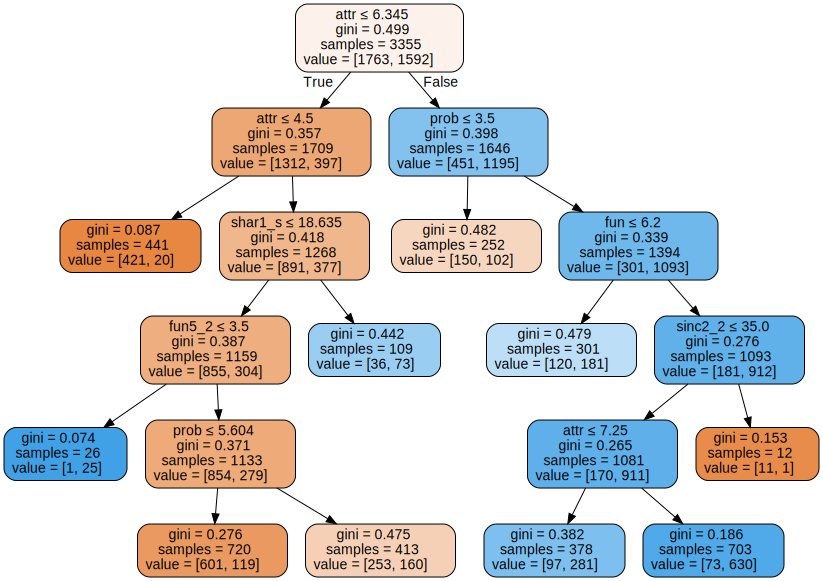

In [186]:
fem_model_20 = model(X[X.gender == 1], Y[X.gender == 1], test_size=0.8)
vizualize(fem_model_20)


    Accuracy: 0.73%
    True negatives: 0.59%	False negatives: 0.04%
    False positives: 0.22%	True positives: 0.14%
    


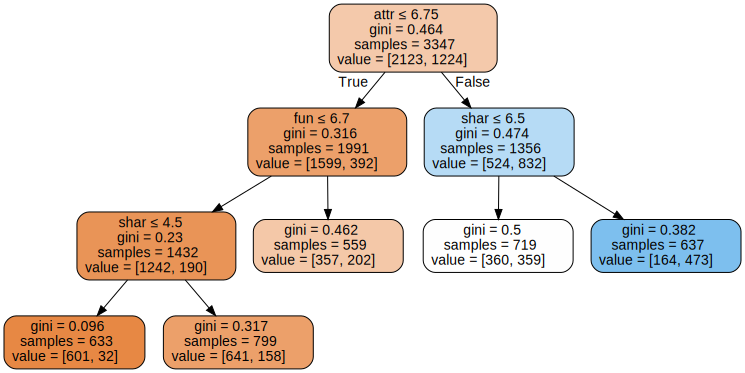

In [187]:
man_model_80 = model(X[X.gender == 0], Y[X.gender == 0], test_size=0.2)
vizualize(man_model_80)